# Classificação de poemas de heterónimos de Fernando Pessoa

## Experiência Interruptor com modelo LDA

## Passo 1: Importar as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import pickle 
import pyLDAvis

## Passo 1: Carregar os dados e filtrá-los

In [2]:
df = pd.read_csv('textos-pessoa.csv', index_col="autor")
df.head(10)

,título,texto,data,tipo
autor,,,,
Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,ESTÉTICA Um exemplo especialmente precioso é ...,1916?,prosa
Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...","Há três espécies de Portugal, dentro do mesmo ...",s.d.,prosa
Alberto Caeiro,"Verdade, mentira, certeza, incerteza…","Verdade, mentira, certeza, incerteza…\nAquele ...",12-4-1919,poesia
Ricardo Reis,OS DEUSES: DEFESA DELES,"OS DEUSES: DEFESA DELES\n\nTemos, como único d...",s.d.,prosa
Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],"Ophelinha:\n\nPara me mostrar o seu desprezo, ...",1-3-1920,prosa
Fernando Pessoa,Out of a great nebula of Night and Storm,Out of a great nebula of Night and Storm \nBor...,5-5-1915,prosa
Barão de Teive,"Viu-a desaparecer com mágoa, com rancor,","Viu-a desaparecer com mágoa, com rancor, com h...",s.d.,prosa
Alberto Caeiro,O amor é uma companhia,O amor é uma companhia.\nJá não sei andar só p...,10-7-1930,poesia
Fernando Pessoa,PRECISAMOS CRIAR PORTUGUESES,PRECISAMOS CRIAR PORTUGUESES\n\n\nO fundo da r...,s.d.,prosa


## Passo 2: Preprocessamento: stemização, lematização, etc. 

Deixamos cair os heterónimos que não precisamos.

In [3]:
df.reset_index(inplace=True)

autores_principais = ['Fernando Pessoa', 'Bernardo Soares', 'Álvaro de Campos', 'Ricardo Reis', 'Alberto Caeiro']
dados = df[df['autor'].isin(autores_principais)].copy()
dados.autor.value_counts()

Fernando Pessoa     2814
Bernardo Soares      504
Álvaro de Campos     397
Ricardo Reis         307
Alberto Caeiro       127
Name: autor, dtype: int64

In [4]:
df

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,ESTÉTICA Um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...","Há três espécies de Portugal, dentro do mesmo ...",s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…","Verdade, mentira, certeza, incerteza…\nAquele ...",12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,"OS DEUSES: DEFESA DELES\n\nTemos, como único d...",s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],"Ophelinha:\n\nPara me mostrar o seu desprezo, ...",1-3-1920,prosa
...,...,...,...,...,...
4525,Eduardo Lança,ESTÁTUAS,ESTÁTUAS\n\nO bom Deus - em pequeno ouvi dizer...,24-5-1902,poesia
4526,Fernando Pessoa,«Vesti-me toda de novo,«Vesti-me toda de novo\n\n«Vesti-me toda de no...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,ESTÉTICA\n\nUm grande artista (literário) nota...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...","Por fácil que seja, todo o gesto representa a ...",s.d.,prosa


Removemos pontuação, maiúsculas e quebras de linha.


In [5]:
def limpar_texto(serie_pandas):
    novo_texto = re.sub(r'[^\w\s]', ' ', serie_pandas).lower()
    novo_texto = re.sub(r'[\n]', ' ', novo_texto).lower()
    return novo_texto

dados.texto = dados.texto.apply(limpar_texto)
dados

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,estética um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...",há três espécies de portugal dentro do mesmo ...,s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…",verdade mentira certeza incerteza aquele c...,12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,os deuses defesa deles temos como único dad...,s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],ophelinha para me mostrar o seu desprezo ou...,1-3-1920,prosa
...,...,...,...,...,...
4523,Fernando Pessoa,"A nossa ânsia de verdade é grande,",a nossa ânsia de verdade é grande e por certo...,s.d.,prosa
4526,Fernando Pessoa,«Vesti-me toda de novo,vesti me toda de novo vesti me toda de novo...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,estética um grande artista literário nota s...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...",por fácil que seja todo o gesto representa a ...,s.d.,prosa


Removemos texto em inglês.

In [6]:
dados = dados[dados.texto.apply(lambda x : detect(x))!='en']

In [7]:
dados

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,estética um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...",há três espécies de portugal dentro do mesmo ...,s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…",verdade mentira certeza incerteza aquele c...,12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,os deuses defesa deles temos como único dad...,s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],ophelinha para me mostrar o seu desprezo ou...,1-3-1920,prosa
...,...,...,...,...,...
4523,Fernando Pessoa,"A nossa ânsia de verdade é grande,",a nossa ânsia de verdade é grande e por certo...,s.d.,prosa
4526,Fernando Pessoa,«Vesti-me toda de novo,vesti me toda de novo vesti me toda de novo...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,estética um grande artista literário nota s...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...",por fácil que seja todo o gesto representa a ...,s.d.,prosa


In [8]:
# remover stopwords

stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords_pt.append("porque")
dados['sem_stopwords'] = dados.apply(lambda x : ' '.join([palavra for palavra in x['texto'].split(' ') if palavra not in stopwords_pt]), axis = 1)


/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
#tokenização

nltk.download('punkt')

tokens = nltk.word_tokenize(dados['sem_stopwords'][2])
dados['tokens'] = dados['sem_stopwords'].apply(nltk.word_tokenize)


[nltk_data] Downloading package punkt to /home/rute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Stemming
nltk.download('rslp')
ps = nltk.stem.RSLPStemmer()

dados['raiz'] = dados.apply(lambda x : [ps.stem(palavra) for palavra in x['tokens']], axis = 1)



[nltk_data] Downloading package rslp to /home/rute/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Word Cloud

In [11]:
wordcloud_df = dados

ric_reis = wordcloud_df[wordcloud_df["autor"] == "Ricardo Reis"]
alv_camp = wordcloud_df[wordcloud_df["autor"] == "Álvaro de Campos"]
alb_caer = wordcloud_df[wordcloud_df["autor"] == "Alberto Caeiro"]
fern_pes = wordcloud_df[wordcloud_df["autor"] == "Fernando Pessoa"]
bern_soar = wordcloud_df[wordcloud_df["autor"] == "Bernardo Soares"]

Ricardo Reis


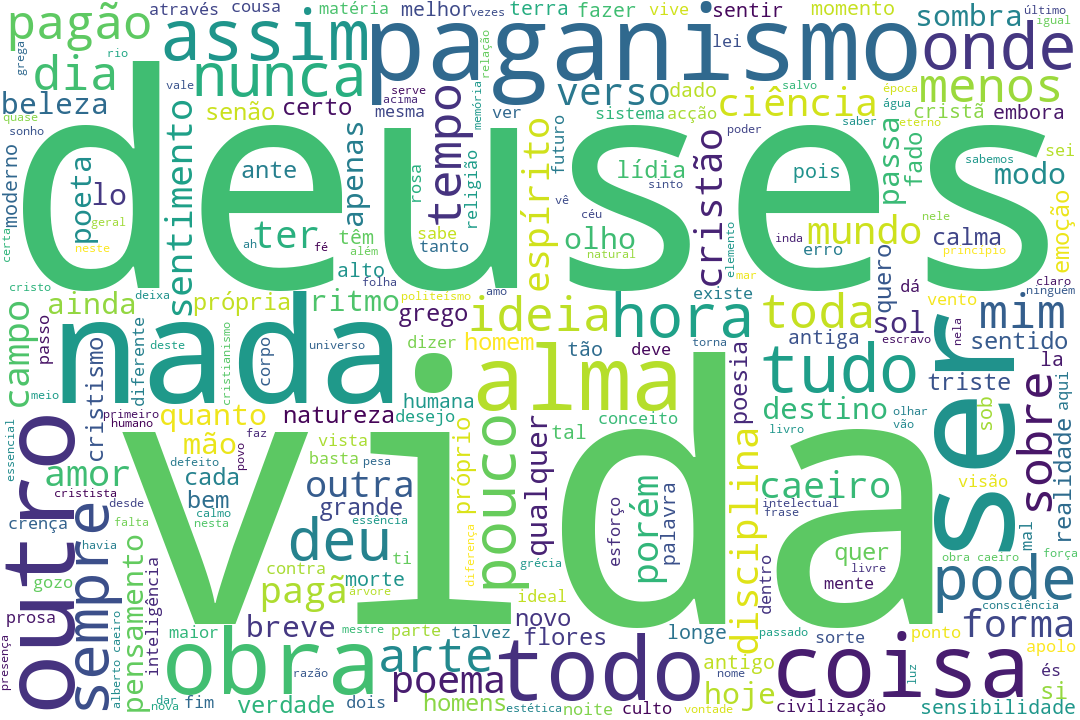

In [12]:
# Join the different processed titles together.
long_string_rr = ','.join(list(ric_reis['sem_stopwords'].values))
long_string_alv = ','.join(list(alv_camp['sem_stopwords'].values))
long_string_alb = ','.join(list(alb_caer['sem_stopwords'].values))
long_string_fp = ','.join(list(fern_pes['sem_stopwords'].values))
long_string_bs = ','.join(list(bern_soar['sem_stopwords'].values))

# Create a WordCloud object
#https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

wordcloud = WordCloud(background_color="white", width=1080, height=720, max_words=250)

# Generate a word cloud

# Visualize the word cloud
print("Ricardo Reis")
wordcloud.generate(long_string_rr)
wordcloud.to_file("nuvem-ricardo-reis.png")
wordcloud.to_image()

Álvaro de Campos


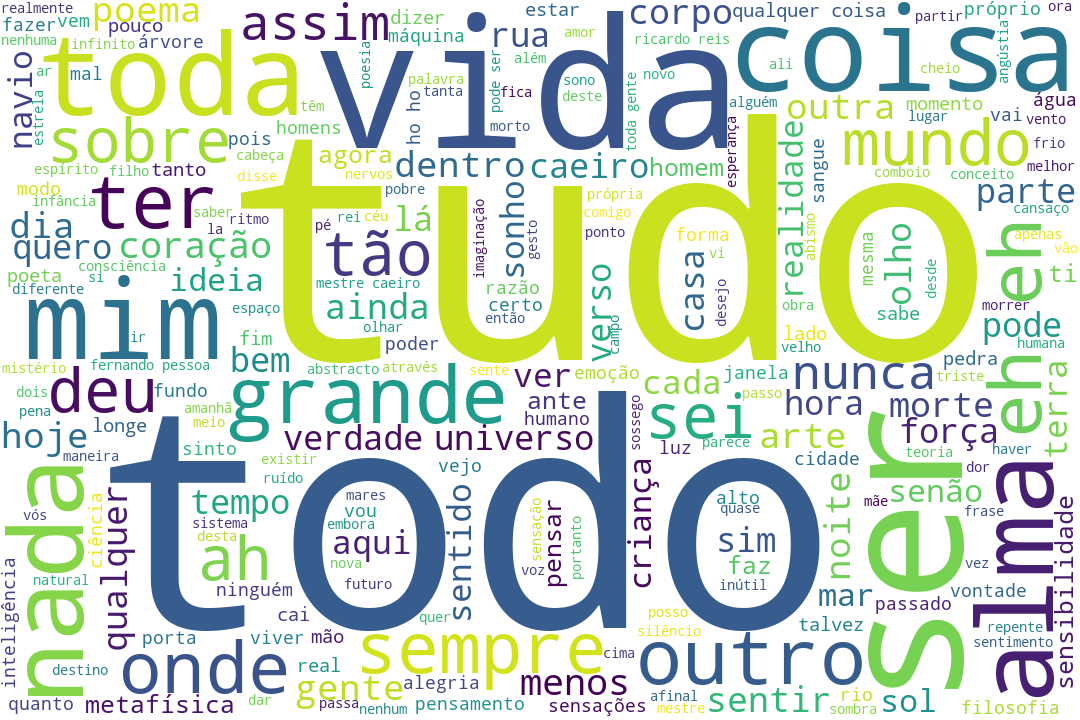

In [13]:
print("Álvaro de Campos")
wordcloud.generate(long_string_alv)
wordcloud.to_file("nuvem-alvaro-campos.png")
wordcloud.to_image()

Alberto Caeiro


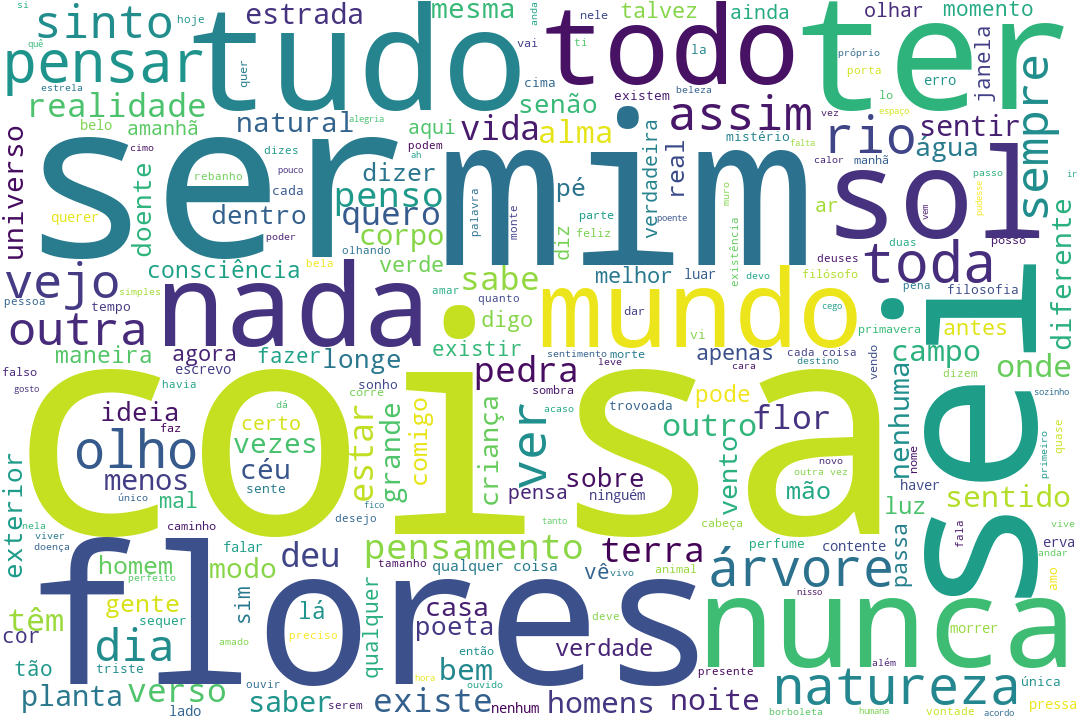

In [14]:
print("Alberto Caeiro")
wordcloud.generate(long_string_alb)
wordcloud.to_file("nuvem-alberto-caeiro.png")
wordcloud.to_image()

Fernando Pessoa


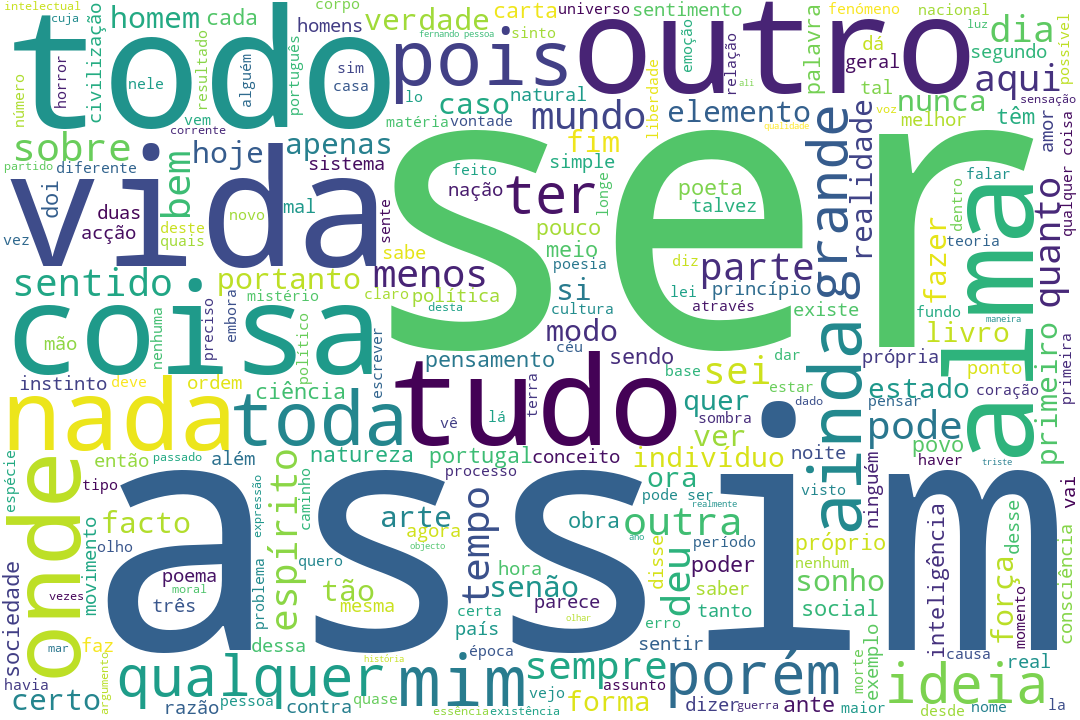

In [15]:
print("Fernando Pessoa")
wordcloud.generate(long_string_fp)
wordcloud.to_file("nuvem-fernando-pessoa.png")
wordcloud.to_image()

Bernardo Soares


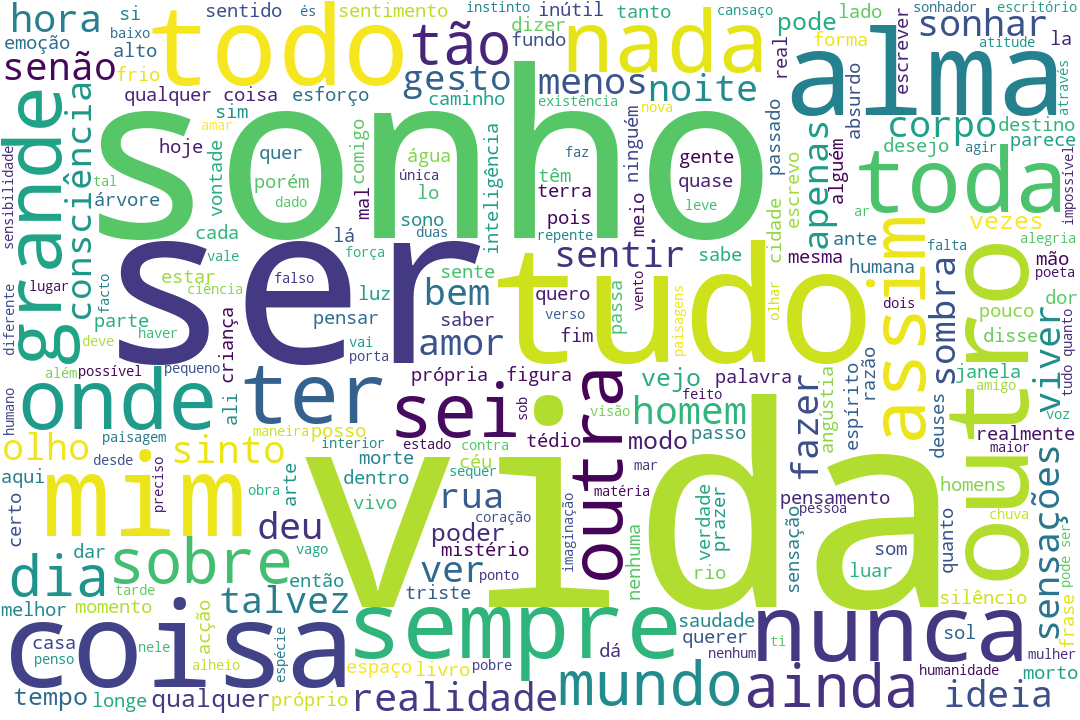

In [16]:
print("Bernardo Soares")
wordcloud.generate(long_string_bs)
wordcloud.to_file("nuvem-bernardo-soares.png")
wordcloud.to_image()

# Train / Test

In [17]:
y = dados['tokens']
X = dados.drop(['tokens'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


# Bag of Words

In [18]:
processed_docs = y_train

id2word = gensim.corpora.Dictionary(processed_docs)

In [19]:
processed_docs

4043    [acabar, versos, acabar, versos, feitos, modo,...
1281    [mistério, olhos, olhar, sujeito, objecto, tra...
1519    [momento, imperceptível, coisa, foste, mim, qu...
2600    [deus, cansado, ser, deus, vão, farto, gente, ...
3131    [prefácio, considerações, pós, revolucionárias...
                              ...                        
537     [história, literatura, inglesa, história, povo...
2604    [l, d, tudo, doença, incurável, ociosidade, se...
3892    [noite, 26, 6, 1915, irmão, pseudo, saberás, h...
2934    [entrevistas, escritor, fernando, pessoa, expõ...
1389    [nesta, grande, oscilação, crer, mal, descrer,...
Name: tokens, Length: 2560, dtype: object

In [20]:
id2word.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

In [21]:
#impressão para verificação

document_num = 20
bow_doc_x = corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Palavra {} (\"{}\") aparece {} vez(es).".format(bow_doc_x[i][0], 
                                                     id2word[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Palavra 53 ("cristianismo") aparece 1 vez(es).
Palavra 140 ("melhor") aparece 1 vez(es).
Palavra 143 ("nisto") aparece 1 vez(es).
Palavra 171 ("verdadeiro") aparece 3 vez(es).
Palavra 229 ("real") aparece 1 vez(es).
Palavra 295 ("realidade") aparece 1 vez(es).
Palavra 308 ("superior") aparece 2 vez(es).
Palavra 319 ("destino") aparece 1 vez(es).
Palavra 376 ("deuses") aparece 3 vez(es).
Palavra 381 ("divina") aparece 1 vez(es).
Palavra 402 ("havia") aparece 1 vez(es).
Palavra 424 ("paganismo") aparece 3 vez(es).
Palavra 425 ("pagã") aparece 1 vez(es).
Palavra 440 ("própria") aparece 1 vez(es).
Palavra 514 ("abstracto") aparece 1 vez(es).
Palavra 515 ("acima") aparece 1 vez(es).
Palavra 516 ("apesar") aparece 1 vez(es).
Palavra 517 ("certa") aparece 2 vez(es).
Palavra 518 ("cristismo") aparece 2 vez(es).
Palavra 519 ("dessa") aparece 1 vez(es).
Palavra 520 ("direcção") aparece 4 vez(es).
Palavra 521 ("disto") aparece 1 vez(es).
Palavra 522 ("diversa") aparece 1 vez(es).
Palavra 523 ("do

In [22]:
lda_model =  gensim.models.LdaMulticore(corpus, 
                                   num_topics = 10, 
                                   id2word = id2word,                 
                                   passes = 20, alpha = 0.02,
                                   workers = 2)

In [23]:
'''
Para cada tópico, mostrar palavras-chave e o respectivo peso relativo.
'''
for idx, topic in lda_model.print_topics(-1):
    print("Tópico: {} \nPalavras: {}".format(idx, topic ))
    print("\n")



Tópico: 0 
Palavras: 0.012*"coração" + 0.011*"sol" + 0.007*"deuses" + 0.007*"luz" + 0.007*"mar" + 0.006*"passa" + 0.006*"rio" + 0.006*"longe" + 0.005*"verde" + 0.005*"vejo"


Tópico: 1 
Palavras: 0.009*"social" + 0.008*"civilização" + 0.005*"sociedade" + 0.005*"política" + 0.005*"povo" + 0.005*"estado" + 0.005*"portugal" + 0.005*"nação" + 0.004*"três" + 0.004*"meio"


Tópico: 2 
Palavras: 0.020*"inteligência" + 0.016*"arte" + 0.016*"instinto" + 0.012*"obra" + 0.009*"emoção" + 0.008*"ideias" + 0.008*"ideia" + 0.008*"poesia" + 0.008*"palavra" + 0.007*"ritmo"


Tópico: 3 
Palavras: 0.021*"pessoa" + 0.018*"fernando" + 0.016*"poemas" + 0.015*"livro" + 0.014*"la" + 0.013*"1" + 0.012*"l" + 0.012*"2" + 0.011*"3" + 0.011*"c"


Tópico: 4 
Palavras: 0.011*"realidade" + 0.009*"ideia" + 0.007*"ciência" + 0.007*"sensação" + 0.006*"poesia" + 0.006*"consciência" + 0.006*"objecto" + 0.006*"arte" + 0.006*"metafísica" + 0.006*"espaço"


Tópico: 5 
Palavras: 0.009*"noite" + 0.009*"sinto" + 0.006*"pensar" 

In [24]:
# verficação da marca de coerência
coherence_model_lda = CoherenceModel(model=lda_model, texts=dados['tokens'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nMarca de coerência: ', coherence_lda)


Marca de coerência:  0.5155314199481354


In [25]:
# Visualização de tópicos
pyLDAvis.enable_notebook()

LDAvis_train = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#pyLDAvis.save_html(LDAvis_train, 'lda.html')
LDAvis_train





PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.159278  0.064545       1        1  22.398836
5     -0.192512  0.030072       2        1  18.085962
4      0.138928  0.091193       3        1  14.061703
8      0.078558 -0.040812       4        1  10.943944
9     -0.145361  0.118062       5        1   7.989959
0     -0.210269  0.043077       6        1   7.527910
2      0.144477  0.107219       7        1   6.876827
7      0.030887 -0.003481       8        1   4.468654
3      0.098636 -0.224490       9        1   4.031911
6     -0.102621 -0.185385      10        1   3.614294, topic_info=          Term        Freq       Total Category  logprob  loglift
359     caeiro  290.000000  290.000000  Default  30.0000  30.0000
498          ó  394.000000  394.000000  Default  29.0000  29.0000
203          2  387.000000  387.000000  Default  28.0000  28.0000
202          1  380.000000  380.000000  Default  27.0000  27.0000
67       noite  478.000000  478.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1840     tarde   37.940666  151.213043  Topic10  -5.1740   1.9376
65          lá   46.352741  345.380035  Topic10  -4.9738   1.3119
232       duas   43.407864  426.494873  Topic10  -5.0394   1.0353
117   escrever   34.959232  234.491730  Topic10  -5.2558   1.4170
188   fernando   29.974514  227.021652  Topic10  -5.4097   1.2956

[646 rows x 6 columns], token_table=      Topic      Freq Term
term                      
202       1  0.257569    1
202       3  0.262826    1
202       4  0.007885    1
202       7  0.002628    1
202       8  0.005257    1
...     ...       ...  ...
498       2  0.151967    ó
498       5  0.744638    ó
498       6  0.083582    ó
498       8  0.007598    ó
498      10  0.010131    ó

[2995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 9, 10, 1, 3, 8, 4, 7])